# Feature selection and modelling
---

## Dependencies

In [1]:
!pip install -qq feature-engine
!pip install -qq shap
!pip install -qq xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import numpy as np

# Feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from scipy.stats import chi2_contingency
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import xgboost as xgb


# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay

# Misc
from collections import Counter
import time
import joblib

# Oversampling
from sklearn.metrics import make_scorer
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE
)

from imblearn.pipeline import Pipeline

## Data

In [3]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/OCL/P7/data/'
!ls '/content/drive/My Drive/OCL/P7/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
application_test.csv		    model.pkl
application_train.csv		    my_gbm.pkl
bureau_balance.csv		    POS_CASH_balance.csv
bureau.csv			    previous_application.csv
checkpoint_1_test.csv		    sample_submission.csv
checkpoint_1_train.csv		    X_test_26.pkl
checkpoint_2_test.csv		    X_test_45.csv
checkpoint_2_train.csv		    X_test.csv
credit_card_balance.csv		    X_train_26.pkl
data_drift_report.html		    X_train_45.csv
HomeCredit_columns_description.csv  X_train.csv
installments_payments.csv	    X_train_target.csv


In [4]:
X = pd.read_csv(path+'X_train.csv')
x_testing = pd.read_csv(path+'X_test.csv')

In [5]:
X.drop(columns=['SK_ID_PREV_y'], inplace=True)
x_testing.drop(columns=['SK_ID_PREV_y'], inplace=True)

In [6]:
X['TARGET'].to_csv(path+'X_train_target.csv', index=False)

## Aux functions

In [7]:
def highly_correlated_columns(df, threshold=0.7):
    """
    Picks out highly correlated columns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): The correlation threshold. Columns with a correlation
      coefficient greater than or equal to this threshold will be selected.

    Returns:
    - List of column names that are highly correlated.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Create a mask for selecting highly correlated columns
    mask = (corr_matrix >= threshold) & (corr_matrix < 1.0)  # Exclude self-correlation (diagonal)

    # Get the names of highly correlated columns
    correlated_columns = set()
    for col in mask.columns:
        correlated_columns.update(mask.index[mask[col]].tolist())

    return list(correlated_columns)

In [8]:
def gen_roc_curve(y_test, y_score):
  TFP, TVP, thresholds = roc_curve(y_test, y_score)
  gmeans = np.sqrt(TVP * (1-TFP))
  ix = np.argmax(gmeans)
  print(f"Best-Threshold={thresholds[ix]:.2%}, G-Mean={gmeans[ix]:.2%}")
  fig, ax = plt.subplots(figsize=(6, 4))

  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(TFP, TVP, linestyle='-', linewidth=2, label='ROC')
  plt.scatter(TFP[ix], TVP[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.legend()
  # show the plot
  plt.show()

In [9]:
def gen_conf_matrix(y_true, y_pred):
  cf = confusion_matrix(y_true, y_pred)
  conf_matrix_normalized = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cf, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt=".1f")

In [10]:
def perform_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = (2 * precision * recall) / (precision + recall)
  accuracy = (tp + tn) / (tn + fp + fn + tp)
  return precision, recall, f1, accuracy

In [11]:
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [12]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-2)
    return scores

## Preprocessing and binarizing columns

In [13]:
X.shape, x_testing.shape

((280830, 57), (45929, 56))

In [14]:
y = X['TARGET']
X.drop(columns=['TARGET'], inplace=True)

In [15]:
for column in X.select_dtypes(exclude=[np.number]).columns:
  X = pd.get_dummies(X, columns=[column])
  x_testing = pd.get_dummies(x_testing, columns=[column])

In [16]:
X.shape, x_testing.shape

((280830, 109), (45929, 106))

In [17]:
for column in X.select_dtypes(exclude=[np.number]).columns:
  print(column)

for column in x_testing.select_dtypes(exclude=[np.number]).columns:
  print(column)

## Variance filters

In [18]:
var_thr = VarianceThreshold(threshold=0.10)
var_thr.fit(X)

concol = [column for column in X.columns
          if column not in X.columns[var_thr.get_support()]]

for features in concol:
    print(features)

EXT_SOURCE_2
NAME_CONTRACT_TYPE_cash_loans
NAME_CONTRACT_TYPE_revolving_loans
CNT_CHILDREN_Two or more children
NAME_TYPE_SUITE_Others
NAME_INCOME_TYPE_Maternity leave
NAME_INCOME_TYPE_State servant
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed
NAME_EDUCATION_TYPE_Academic degree
NAME_EDUCATION_TYPE_Incomplete higher
NAME_EDUCATION_TYPE_Lower secondary
NAME_HOUSING_TYPE_dependent
NAME_HOUSING_TYPE_independent
WEEKDAY_APPR_PROCESS_START_SATURDAY
WEEKDAY_APPR_PROCESS_START_SUNDAY
REG_REGION_NOT_LIVE_REGION_different address
REG_REGION_NOT_LIVE_REGION_same address
REG_REGION_NOT_WORK_REGION_different address
REG_REGION_NOT_WORK_REGION_same address
LIVE_REGION_NOT_WORK_REGION_different address
LIVE_REGION_NOT_WORK_REGION_same address
REG_CITY_NOT_LIVE_CITY_different address
REG_CITY_NOT_LIVE_CITY_same address


In [19]:
concol.remove('EXT_SOURCE_2')

In [20]:
concol

['NAME_CONTRACT_TYPE_cash_loans',
 'NAME_CONTRACT_TYPE_revolving_loans',
 'CNT_CHILDREN_Two or more children',
 'NAME_TYPE_SUITE_Others',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_HOUSING_TYPE_dependent',
 'NAME_HOUSING_TYPE_independent',
 'WEEKDAY_APPR_PROCESS_START_SATURDAY',
 'WEEKDAY_APPR_PROCESS_START_SUNDAY',
 'REG_REGION_NOT_LIVE_REGION_different address',
 'REG_REGION_NOT_LIVE_REGION_same address',
 'REG_REGION_NOT_WORK_REGION_different address',
 'REG_REGION_NOT_WORK_REGION_same address',
 'LIVE_REGION_NOT_WORK_REGION_different address',
 'LIVE_REGION_NOT_WORK_REGION_same address',
 'REG_CITY_NOT_LIVE_CITY_different address',
 'REG_CITY_NOT_LIVE_CITY_same address']

In [21]:
X.drop(columns=concol, inplace=True)
x_testing.drop(columns=concol, inplace=True, errors='ignore')

## Correlations

## Chi squared test

In [22]:
chi2_cols = []
for column in X.columns:
  if X[column].nunique() == 2:
    chi2_cols.append(column)

In [23]:
chi2_cols

['paid_less_than_ins',
 'paid_more_than_ins',
 'late_with_previous_ins_yes',
 'CODE_GENDER_Female',
 'CODE_GENDER_Male',
 'FLAG_OWN_CAR_No',
 'FLAG_OWN_CAR_Yes',
 'FLAG_OWN_REALTY_No',
 'FLAG_OWN_REALTY_Yes',
 'CNT_CHILDREN_No children',
 'CNT_CHILDREN_Single child',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_married',
 'NAME_FAMILY_STATUS_not married',
 'FLAG_EMP_PHONE_No',
 'FLAG_EMP_PHONE_Yes',
 'FLAG_WORK_PHONE_No',
 'FLAG_WORK_PHONE_Yes',
 'FLAG_PHONE_No',
 'FLAG_PHONE_Yes',
 'CNT_FAM_MEMBERS_more than two',
 'CNT_FAM_MEMBERS_one',
 'CNT_FAM_MEMBERS_two',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 

In [24]:
chi_ls = []
for feature in chi2_cols:
    # create contingency table
    c = pd.crosstab(y, X[feature])
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

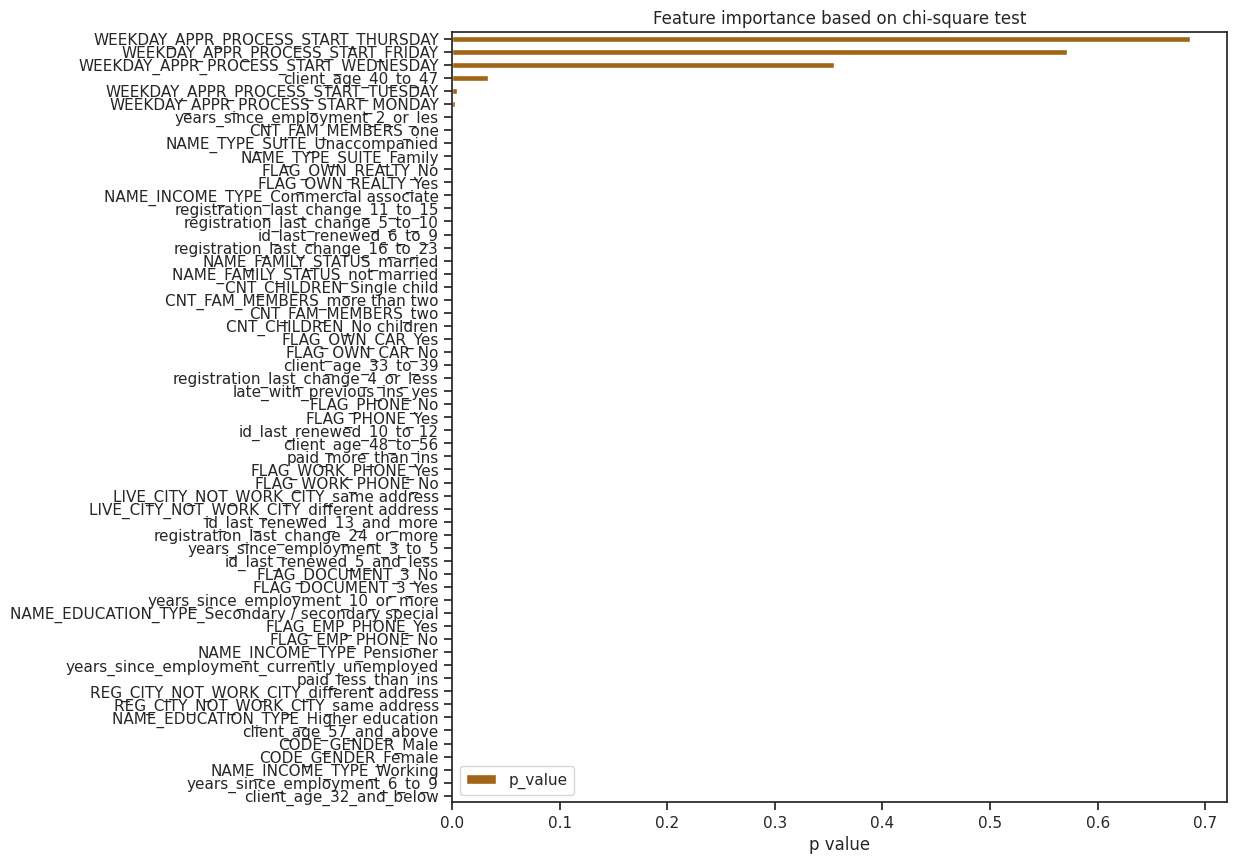

In [25]:
sns.set(style="ticks", rc={'figure.figsize': (10, 10)}, palette="BrBG")

df_pvalue = pd.DataFrame(chi_ls, index=chi2_cols, columns=['p_value']).sort_values(by='p_value', ascending=True)

pd.set_option('display.float_format', '{:,.3f}'.format)
#print(df_pvalue)

df_pvalue.plot.barh()
plt.xlabel('p value')
plt.title('Feature importance based on chi-square test')
plt.show()

In [26]:
vars_to_drop = ['WEEKDAY_APPR_PROCESS_START_THURSDAY',
                'WEEKDAY_APPR_PROCESS_START_FRIDAY',
                'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
                'client_age_40_to_47']

In [27]:
X.drop(columns=vars_to_drop, inplace=True)
x_testing.drop(columns=vars_to_drop, inplace=True, errors='ignore')

### Change categorical data types

In [28]:
bin = Counter([0, 1])
for column in X.columns:
  test_bin = Counter(X[column].unique().tolist())
  if test_bin == bin:
    X[column] = X[column].astype('int8')

In [29]:
for column in x_testing.columns:
  test_bin = Counter(x_testing[column].unique().tolist())
  if test_bin == bin:
    x_testing[column] = x_testing[column].astype('int8')

### Remove duplicated features

In [30]:
duplicated_feat_pairs = {}

_duplicated_feat = []

for i in range(0, len(X.columns)):

    # ce bit aide à comprendre où se trouve la boucle:
    if i % 10 == 0:
        print(i)

    # choose 1 feature:
    feat_1 = X.columns[i]

    if feat_1 not in _duplicated_feat:

        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in X.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if X[feat_1].equals(X[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)

                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)

0
10
20
30
40
50
60
70
80


In [31]:
_duplicated_feat

[]

### Removing correlated columns

In [32]:
selec = DropCorrelatedFeatures(threshold=0.8,
                               method='spearman',
                               missing_values='ignore'
                               )
selec.fit(X)

DropCorrelatedFeatures(method='spearman')

In [33]:
selec.correlated_feature_sets_

[{'MONTHS_BALANCE_x', 'number_of_years_since_last_decision'},
 {'AMT_CREDIT_SUM',
  'credit_bureau_status_active_no_delay',
  'credit_bureau_status_closed'},
 {'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE'},
 {'CODE_GENDER_Female', 'CODE_GENDER_Male'},
 {'FLAG_OWN_CAR_No', 'FLAG_OWN_CAR_Yes'},
 {'FLAG_OWN_REALTY_No', 'FLAG_OWN_REALTY_Yes'},
 {'CNT_CHILDREN_No children', 'CNT_FAM_MEMBERS_more than two'},
 {'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Unaccompanied'},
 {'FLAG_EMP_PHONE_No',
  'FLAG_EMP_PHONE_Yes',
  'NAME_INCOME_TYPE_Pensioner',
  'years_since_employment_10_or_more'},
 {'NAME_EDUCATION_TYPE_Higher education',
  'NAME_EDUCATION_TYPE_Secondary / secondary special'},
 {'CNT_FAM_MEMBERS_one',
  'NAME_FAMILY_STATUS_married',
  'NAME_FAMILY_STATUS_not married'},
 {'FLAG_WORK_PHONE_No', 'FLAG_WORK_PHONE_Yes'},
 {'FLAG_PHONE_No', 'FLAG_PHONE_Yes'},
 {'LIVE_CITY_NOT_WORK_CITY_different address',
  'LIVE_CITY_NOT_WORK_CITY_same address',
  'REG_CITY_NOT_WORK_CITY_different address',
  '

In [34]:
sel = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
    scoring="roc_auc",
    cv=3,
)

sel.fit(X, y)

SmartCorrelatedSelection(missing_values='raise', selection_method='variance')

In [35]:
sel.features_to_drop_

['CNT_INSTALMENT_FUTURE',
 'CODE_GENDER_Male',
 'FLAG_OWN_CAR_No',
 'FLAG_OWN_REALTY_No',
 'NAME_TYPE_SUITE_Family',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_FAMILY_STATUS_not married',
 'FLAG_EMP_PHONE_No',
 'FLAG_EMP_PHONE_Yes',
 'FLAG_WORK_PHONE_Yes',
 'FLAG_PHONE_Yes',
 'CNT_FAM_MEMBERS_more than two',
 'CNT_FAM_MEMBERS_one',
 'REG_CITY_NOT_WORK_CITY_same address',
 'LIVE_CITY_NOT_WORK_CITY_different address',
 'LIVE_CITY_NOT_WORK_CITY_same address',
 'FLAG_DOCUMENT_3_Yes']

In [36]:
X.drop(columns=sel.features_to_drop_, inplace=True, errors='ignore')
x_testing.drop(columns=sel.features_to_drop_, inplace=True, errors='ignore')

In [37]:
X.shape, x_testing.shape

((280830, 64), (45929, 64))

### Scaling the data

In [38]:
for column in X.select_dtypes(exclude='int8').columns:
  print(column)
  print(X[column].value_counts())
  print("------------")

SK_ID_CURR
100002    1
337795    1
337803    1
337800    1
337799    1
         ..
219004    1
219005    1
219007    1
219008    1
456255    1
Name: SK_ID_CURR, Length: 280830, dtype: int64
------------
AMT_INCOME_TOTAL
135,000.000    32979
112,500.000    28758
157,500.000    24541
180,000.000    22700
90,000.000     20825
               ...  
49,522.500         1
320,850.000        1
98,158.500         1
90,877.500         1
113,062.500        1
Name: AMT_INCOME_TOTAL, Length: 1771, dtype: int64
------------
AMT_CREDIT
450,000.000      8949
675,000.000      8116
225,000.000      7499
180,000.000      6915
270,000.000      6893
                 ... 
1,373,449.500       1
218,232.000         1
1,565,887.500       1
1,022,130.000       1
1,391,130.000       1
Name: AMT_CREDIT, Length: 5446, dtype: int64
------------
EXT_SOURCE_2
0.286    651
0.566    548
0.262    395
0.265    330
0.160    311
        ... 
0.568      1
0.561      1
0.788      1
0.032      1
0.268      1
Name: EXT_SOURCE_2

In [39]:
X_cat = X.select_dtypes(include='int8')
scaler = StandardScaler()
scaler.fit(X.select_dtypes(exclude='int8').drop(labels='SK_ID_CURR', axis=1))

X_scaled_cont = scaler.transform(X.select_dtypes(exclude='int8').drop(labels='SK_ID_CURR', axis=1))

In [40]:
X_scaled_cont = pd.DataFrame(X_scaled_cont, columns=X.select_dtypes(exclude='int8').drop('SK_ID_CURR', axis=1).columns)

In [41]:
X_scaled = pd.concat([X_scaled_cont, X_cat], axis=1)

In [42]:
# Save sk_ids for later
sk_ids = X['SK_ID_CURR']

In [43]:
#X_scaled['SK_ID_CURR'] = sk_ids

In [44]:
#X_scaled = pd.concat([X[['SK_ID_CURR']], X_scaled], axis=1)

In [45]:
X_scaled

,AMT_INCOME_TOTAL,AMT_CREDIT,EXT_SOURCE_2,repayment_time_months,number_of_previous_loans,previous_amount_credit,number_of_years_since_last_decision,prev_contrat_statut_canceled_unused,prev_contrat_statut_refused,prev_contrat_type_consumer_loans,...,registration_last_change_11_to_15,registration_last_change_16_to_23,registration_last_change_24_or_more,registration_last_change_4_or_less,registration_last_change_5_to_10,years_since_employment_10_or_more,years_since_employment_2_or_les,years_since_employment_3_to_5,years_since_employment_6_to_9,years_since_employment_currently_unemployed
0,0.146,-0.470,-1.305,-0.696,-0.923,0.064,-0.316,-0.565,-0.460,-0.631,...,0,0,0,0,1,0,0,0,1,0
1,0.422,1.798,0.576,1.891,-0.441,1.912,0.520,-0.565,-0.460,-0.081,...,0,0,0,1,0,0,0,1,0,0
2,-0.408,-1.165,0.228,-0.179,-0.923,-0.898,-0.316,-0.565,-0.460,-0.631,...,1,0,0,0,0,0,0,0,1,0
3,-0.131,-0.710,0.723,-1.343,1.007,0.746,-1.290,1.187,0.097,-0.081,...,0,0,1,0,0,0,1,0,0,0
4,-0.187,-0.198,-0.992,0.210,0.283,-0.011,0.415,-0.565,-0.460,-0.081,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280825,-0.039,-0.858,0.886,-1.602,-0.923,-0.775,-0.942,-0.565,-0.460,-0.631,...,0,1,0,0,0,0,0,0,1,0
280826,-0.390,-0.820,-2.075,0.080,-0.923,-0.676,2.816,-0.565,-0.460,-0.631,...,1,0,0,0,0,1,0,0,0,0
280827,-0.058,0.223,0.123,0.210,-0.682,-0.895,2.503,-0.565,-0.460,-0.081,...,0,1,0,0,0,0,0,0,0,1
280828,0.016,-0.563,0.010,-0.437,-0.682,-0.206,-0.942,-0.565,-0.460,-0.081,...,0,0,0,0,1,0,0,0,0,1


## Training a dummy classifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [47]:
dummy_regr = DummyClassifier(strategy="uniform")
dummy_regr.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [48]:
accuracy_score(y_test, dummy_regr.predict(X_test))

0.4966527792614749

<Axes: >

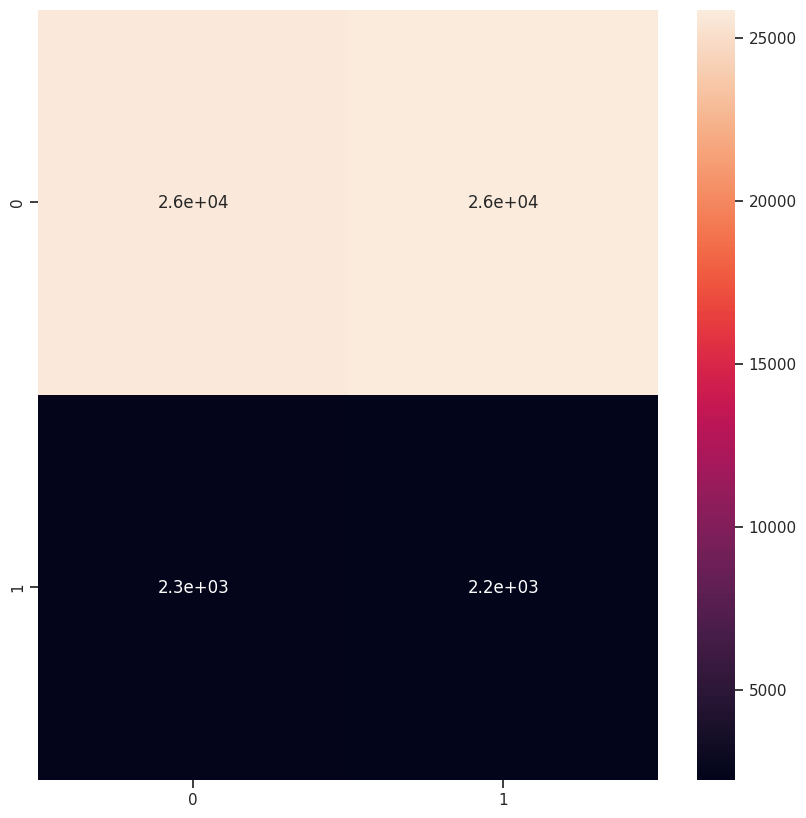

In [49]:
conf_mat = confusion_matrix(y_test, dummy_regr.predict(X_test))
sns.heatmap(conf_mat, annot=True)

In [50]:
y_score = dummy_regr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

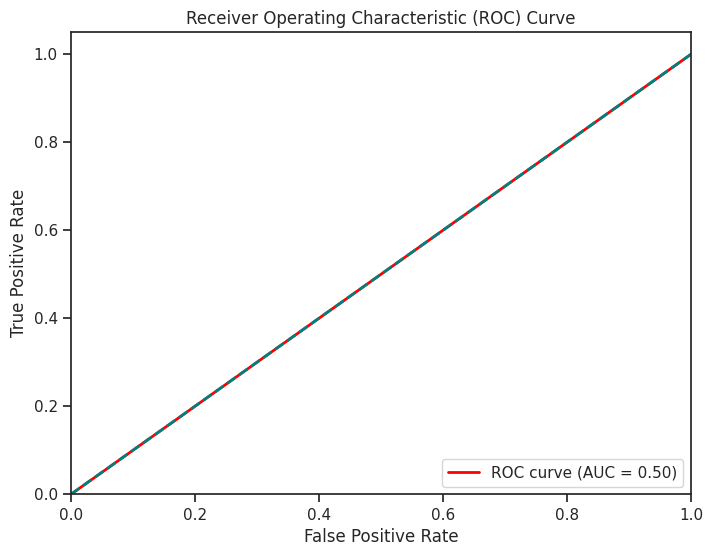

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='teal', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**It's a random classification**

## Other feature selection methods

### Random forest feature importance

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

21

In [ ]:
print(selected_feat)

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EXT_SOURCE_2',
       'repayment_time_months', 'number_of_previous_loans',
       'previous_amount_credit', 'number_of_years_since_last_decision',
       'prev_contrat_statut_canceled_unused', 'prev_contrat_statut_refused',
       'prev_contrat_type_consumer_loans', 'AMT_CREDIT_SUM',
       'bureau_credit_type_credit_card',
       'credit_bureau_status_active_no_delay', 'credit_bureau_status_closed',
       'SK_ID_PREV_x', 'MONTHS_BALANCE_x', 'CNT_INSTALMENT',
       'MONTHS_BALANCE_y', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_CURRENT'],
      dtype='object')


### Recursive feature selection

In [52]:
rfe_method = RFE(
    RandomForestClassifier(n_estimators=10, random_state=42),
    n_features_to_select=25,
    step=2,
)

In [53]:
rfe_method.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=42),
    n_features_to_select=25, step=2)

In [54]:
X_scaled.columns[(rfe_method.get_support())]

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EXT_SOURCE_2',
       'repayment_time_months', 'number_of_previous_loans',
       'previous_amount_credit', 'number_of_years_since_last_decision',
       'prev_contrat_statut_canceled_unused', 'prev_contrat_statut_refused',
       'prev_contrat_type_consumer_loans', 'prev_contrat_type_revolving_loans',
       'AMT_CREDIT_SUM', 'bureau_credit_type_credit_card',
       'credit_bureau_status_active_no_delay', 'credit_bureau_status_closed',
       'SK_ID_PREV_x', 'MONTHS_BALANCE_x', 'CNT_INSTALMENT',
       'MONTHS_BALANCE_y', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_CURRENT', 'late_with_previous_ins_yes',
       'FLAG_OWN_REALTY_Yes', 'CNT_FAM_MEMBERS_two'],
      dtype='object')

In [55]:
X_scaled = X_scaled[X_scaled.columns[(rfe_method.get_support())]]

In [ ]:
feature_ranking = rfe_method.ranking_

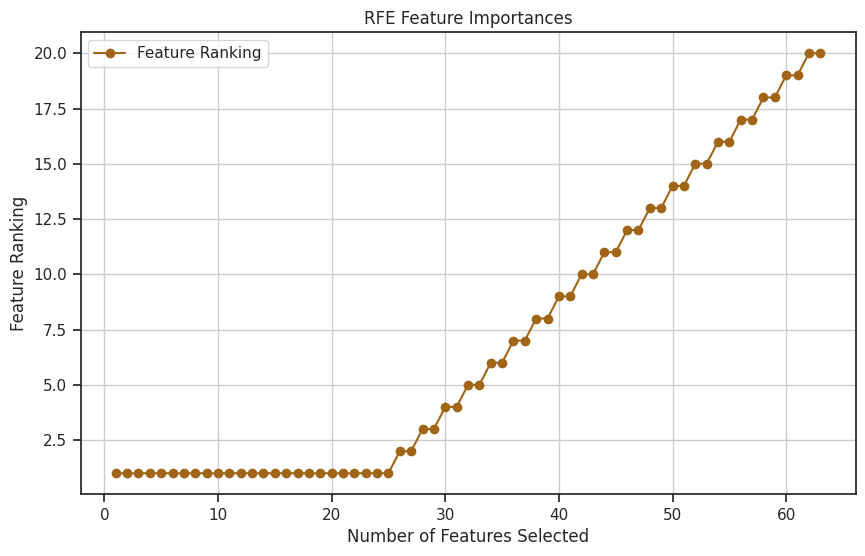

In [ ]:
# Create an array of the number of features selected
num_features_selected = np.arange(1, len(feature_ranking) + 1)
threshold = 1
sorted_indices = np.argsort(feature_ranking)
# Create a line plot for the feature rankings
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, feature_ranking[sorted_indices], marker='o', linestyle='-', label='Feature Ranking')

# Add a horizontal line for the threshold
#plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')

# Customize the plot
plt.xlabel('Number of Features Selected')
plt.ylabel('Feature Ranking')
plt.title('RFE Feature Importances')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

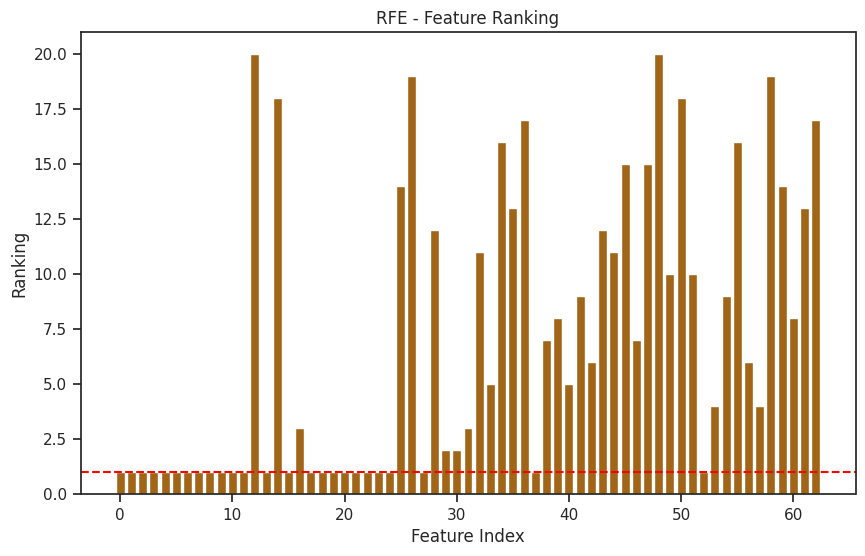

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("RFE - Feature Ranking")
plt.xlabel("Feature Index")
plt.ylabel("Ranking")
plt.bar(range(len(feature_ranking)), feature_ranking)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({1})')
plt.show()

In [ ]:
feature_ranking.sort()

In [ ]:
from yellowbrick.model_selection import RFECV

In [ ]:
from sklearn.svm import SVC
visualizer = RFECV(SVC(kernel='linear', C=1))
visualizer.fit(X, y)
visualizer.show()

In [ ]:
# Create an array of the number of features selected
num_features_selected = np.arange(1, len(feature_ranking) + 1)

# Create a line plot for the feature rankings
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, feature_ranking, marker='o', linestyle='-', label='Feature Ranking')

# Add a horizontal line for the threshold
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')

# Customize the plot
plt.xlabel('Number of Features Selected')
plt.ylabel('Feature Ranking')
plt.title('RFE Feature Importances')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


### Another approach with Cross Validation

In [ ]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20)

select = RFECV(estimator=rfc, cv=5, min_features_to_select=10, step=2, n_jobs=-1)

In [ ]:
select = select.fit(X_train, y_train)

In [ ]:
#mask = select.get_support()
len(X_train.columns[(select.get_support())])

45

**45 features detected** Let's keep those

In [ ]:
X_scaled = X_scaled[X_scaled.columns[(select.get_support())]]

In [ ]:
X_scaled.columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EXT_SOURCE_2',
       'repayment_time_months', 'number_of_previous_loans',
       'previous_amount_credit', 'number_of_years_since_last_decision',
       'prev_contrat_statut_canceled_unused', 'prev_contrat_statut_refused',
       'prev_contrat_type_consumer_loans', 'prev_contrat_type_revolving_loans',
       'AMT_CREDIT_SUM', 'bureau_credit_type_credit_card',
       'credit_bureau_status_active_no_delay',
       'credit_bureau_status_active_with_delay', 'credit_bureau_status_closed',
       'SK_ID_PREV_x', 'MONTHS_BALANCE_x', 'CNT_INSTALMENT',
       'MONTHS_BALANCE_y', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_CURRENT', 'paid_less_than_ins',
       'late_with_previous_ins_yes', 'CODE_GENDER_Female', 'FLAG_OWN_CAR_Yes',
       'FLAG_OWN_REALTY_Yes', 'CNT_CHILDREN_No children',
       'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_married', 'FLAG_WORK_PHONE

In [ ]:
x_testing_sk_ids = x_testing['SK_ID_CURR']

In [ ]:
x_testing = x_testing[X_scaled.columns]
x_testing['SK_ID_CURR'] = x_testing_sk_ids

<ipython-input-59-acc58317b272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_testing['SK_ID_CURR'] = x_testing_sk_ids


In [ ]:
x_testing

,AMT_INCOME_TOTAL,AMT_CREDIT,EXT_SOURCE_2,repayment_time_months,number_of_previous_loans,previous_amount_credit,number_of_years_since_last_decision,prev_contrat_statut_canceled_unused,prev_contrat_statut_refused,prev_contrat_type_consumer_loans,...,MONTHS_BALANCE_x,CNT_INSTALMENT,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,FLAG_OWN_CAR_No,FLAG_OWN_REALTY_Yes,CNT_FAM_MEMBERS_two,SK_ID_CURR
0,"135,000.000","568,800.000",0.790,28.000,1.000,"23,787.000",5.000,0.000,0.000,1.000,...,-72.556,4.000,-12.000,"476,594.258","3,375,000.000","119,367.270",1,1,1,100001
1,"99,000.000","222,768.000",0.292,13.000,2.000,"20,076.750",1.500,1.000,0.000,1.000,...,-20.000,11.700,-12.000,"476,594.258","3,375,000.000","119,367.270",1,1,1,100005
2,"202,500.000","663,264.000",0.700,10.000,4.000,"146,134.125",2.250,1.000,0.000,2.000,...,-29.556,21.389,-48.500,"1,743,352.245","12,645,000.000","571,500.000",0,1,1,100013
3,"315,000.000","1,575,000.000",0.510,32.000,5.000,"92,920.500",3.000,2.000,0.000,3.000,...,-41.968,20.355,-25.000,"396,167.850","11,025,000.000","301,663.620",1,1,0,100028
4,"180,000.000","625,500.000",0.426,20.000,2.000,"300,550.500",1.000,1.000,0.000,1.000,...,-21.000,12.000,-12.000,"476,594.258","3,375,000.000","119,367.270",0,0,0,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45924,"121,500.000","412,560.000",0.649,24.000,1.000,"254,700.000",2.000,0.000,0.000,0.000,...,-20.500,18.750,-12.000,"476,594.258","3,375,000.000","119,367.270",1,1,0,456221
45925,"157,500.000","622,413.000",0.685,20.000,4.000,"98,704.125",4.250,0.000,0.000,3.000,...,-32.162,19.784,-12.000,"476,594.258","3,375,000.000","119,367.270",1,0,0,456222
45926,"202,500.000","315,000.000",0.633,9.000,2.000,"132,516.832",1.000,0.000,0.000,2.000,...,-61.258,8.548,-12.000,"476,594.258","3,375,000.000","119,367.270",0,1,0,456223
45927,"225,000.000","450,000.000",0.446,18.000,5.000,"127,578.600",3.400,1.000,2.000,3.000,...,-33.419,18.581,-12.000,"476,594.258","3,375,000.000","119,367.270",1,0,1,456224


### Save the dataset

In [ ]:
X_scaled['SK_ID_CURR'] = X['SK_ID_CURR']

<ipython-input-57-b6227e7b69c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled['SK_ID_CURR'] = X['SK_ID_CURR']


In [ ]:
X_scaled.to_csv(path+'X_train_45.csv', index=False)
x_testing.to_csv(path+'X_test_45.csv', index=False)

### Sequential Forward selection (crashed)

## Training - LightGBM

In [ ]:
X

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,credit_bureau_status_active_with_delay,credit_bureau_status_closed,SK_ID_PREV_x,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT
0,100002,1,cash_loans,Male,No,Yes,No children,202500.0,406597.5,Unaccompanied,...,27.0,23.0,19.0,-10.000000,24.000000,15.000000,-11.5,728139.4425,3915000.0,146250.0
1,100003,0,cash_loans,Female,No,No,No children,270000.0,1293502.5,Family,...,0.0,0.0,28.0,-43.785714,10.107143,5.785714,-11.5,728139.4425,3915000.0,146250.0
2,100004,0,revolving_loans,Male,Yes,Yes,No children,67500.0,135000.0,Unaccompanied,...,0.0,0.0,4.0,-25.500000,3.750000,2.250000,-11.5,728139.4425,3915000.0,146250.0
3,100006,0,cash_loans,Female,No,Yes,No children,135000.0,312682.5,Unaccompanied,...,0.0,0.0,21.0,-9.619048,12.000000,8.650000,-3.5,0.0000,1620000.0,0.0
4,100007,0,cash_loans,Male,No,Yes,No children,121500.0,513000.0,Unaccompanied,...,0.0,0.0,66.0,-33.636364,15.333333,8.969697,-11.5,728139.4425,3915000.0,146250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280825,456251,0,cash_loans,Male,No,No,No children,157500.0,254700.0,Unaccompanied,...,0.0,0.0,9.0,-5.000000,7.875000,4.375000,-11.5,728139.4425,3915000.0,146250.0
280826,456252,0,cash_loans,Female,No,Yes,No children,72000.0,269550.0,Unaccompanied,...,0.0,0.0,7.0,-79.000000,6.000000,3.000000,-11.5,728139.4425,3915000.0,146250.0
280827,456253,0,cash_loans,Female,No,Yes,No children,153000.0,677664.0,Unaccompanied,...,0.0,57.0,17.0,-79.235294,6.705882,2.000000,-11.5,728139.4425,3915000.0,146250.0
280828,456254,1,cash_loans,Female,No,Yes,No children,171000.0,370107.0,Unaccompanied,...,0.0,29.0,20.0,-5.550000,14.900000,10.350000,-11.5,728139.4425,3915000.0,146250.0


In [ ]:
# Uncomment when needed
X_scaled = pd.read_csv(path+'X_train_45.csv')
x_testing = pd.read_csv(path+'X_test_45.csv')

In [ ]:
X_small = X_scaled

In [ ]:
X_small['TARGET'] = X['TARGET']

In [ ]:
X_small = X_small.sample(frac=1).head(50000)
y_small = X_small['TARGET']
X_small.drop(columns=['TARGET'], inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_small.drop(labels='SK_ID_CURR', axis=1, errors="ignore"), y_small, test_size=0.3, random_state=42)

### Defining training params

In [ ]:
model = LGBMClassifier()
param_grid = [{'class_weight': ['balanced', {0: 100, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]}]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=cv,
                    scoring=make_scorer(fbeta_score, beta=2))

In [ ]:
grid_result = grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2876, number of negative: 32124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3900
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [ ]:
params = grid_result.cv_results_['params']

In [ ]:
params

[{'class_weight': 'balanced'},
 {'class_weight': {0: 100, 1: 1}},
 {'class_weight': {0: 10, 1: 1}},
 {'class_weight': {0: 1, 1: 1}},
 {'class_weight': {0: 1, 1: 10}},
 {'class_weight': {0: 1, 1: 100}}]

In [ ]:
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.361464 using {'class_weight': 'balanced'}


Best-Threshold=42.36%, G-Mean=63.72%


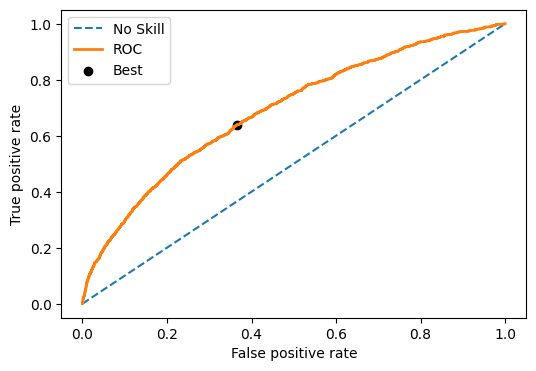

In [ ]:
gen_roc_curve(y_test, grid_result.predict_proba(X_test)[:, 1])

## Oversampling data

In [ ]:
def get_models():
    models, names = list(), list()

    # RandomOverSampler
    models.append(RandomOverSampler(sampling_strategy='auto',
                                    random_state=101))
    names.append('Random_Over_Sampler')

    # SMOTE
    models.append(SMOTE(sampling_strategy='auto',  # samples only the minority class
                        random_state=101,  # for reproducibility
                        k_neighbors=5,
                        n_jobs=-2))
    names.append('SMOTE')

    # ADASYN
    models.append(ADASYN(sampling_strategy='auto',  # samples only the minority class
                        random_state=101,  # for reproducibility
                        n_neighbors=5,
                        n_jobs=-2))
    names.append('ADASYN')

    # BorderlineSMOTE1
    models.append(BorderlineSMOTE(sampling_strategy='auto',  # samples only the minority class
                                  random_state=101,  # for reproducibility
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-1',
                                  n_jobs=-2))
    names.append('Borderline_SMOTE_1')

    # BorderlineSMOTE2
    models.append(BorderlineSMOTE(sampling_strategy='auto',  # samples only the minority class
                                  random_state=101,  # for reproducibility
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-2',
                                  n_jobs=-2))
    names.append('Borderline_SMOTE_2')

    return models, names

In [ ]:
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    temps = time.time()
    # define the model
    model = LGBMClassifier()
    # define the pipeline steps
    steps = [('o', models[i]), ('m', model)]
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline) # Données AVANT STANDARDISATION
    results.append(scores)
    duration=time.time()-temps
    # summarize and store
    print(f"Score F2 du modèle {names[i]} : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")
    print(f"Temps de Calcul pour {names[i]} : {duration:>15.2f} secondes")
    print(end='\n\n')

[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3889
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise m

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5604
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5604
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Score F2 du modèle SMOTE : moyenne = 3.57%, écart_type = 1.09%
Temps de Calcul pour SMOTE :           59.63 secondes




/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29490, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58401, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504957 -> initscore=0.019829
[LightGBM] [Info] Start training from score 0.019829


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29368, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58279, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503921 -> initscore=0.015684
[LightGBM] [Info] Start training from score 0.015684


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29429, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58340, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504439 -> initscore=0.017758
[LightGBM] [Info] Start training from score 0.017758


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29468, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58379, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504771 -> initscore=0.019083
[LightGBM] [Info] Start training from score 0.019083


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29449, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58361, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504601 -> initscore=0.018403
[LightGBM] [Info] Start training from score 0.018403


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29465, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58377, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504736 -> initscore=0.018946
[LightGBM] [Info] Start training from score 0.018946


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29463, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58375, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504719 -> initscore=0.018879
[LightGBM] [Info] Start training from score 0.018879


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29324, number of negative: 28912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58236, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503537 -> initscore=0.014150
[LightGBM] [Info] Start training from score 0.014150


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29476, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 58388, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504830 -> initscore=0.019320
[LightGBM] [Info] Start training from score 0.019320


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29410, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5604
[LightGBM] [Info] Number of data points in the train set: 58322, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504269 -> initscore=0.017078
[LightGBM] [Info] Start training from score 0.017078


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29411, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58322, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504287 -> initscore=0.017147
[LightGBM] [Info] Start training from score 0.017147


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29456, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 58367, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504669 -> initscore=0.018675
[LightGBM] [Info] Start training from score 0.018675


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29416, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58327, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504329 -> initscore=0.017317
[LightGBM] [Info] Start training from score 0.017317


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29471, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58382, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504796 -> initscore=0.019185
[LightGBM] [Info] Start training from score 0.019185


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29419, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 58331, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504346 -> initscore=0.017384
[LightGBM] [Info] Start training from score 0.017384


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29513, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 58425, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505143 -> initscore=0.020574
[LightGBM] [Info] Start training from score 0.020574


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29456, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 58368, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504660 -> initscore=0.018641
[LightGBM] [Info] Start training from score 0.018641


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29325, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58237, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503546 -> initscore=0.014184
[LightGBM] [Info] Start training from score 0.014184


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29424, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 58336, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504388 -> initscore=0.017554
[LightGBM] [Info] Start training from score 0.017554


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29451, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 58363, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504618 -> initscore=0.018471
[LightGBM] [Info] Start training from score 0.018471


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29480, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58391, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504872 -> initscore=0.019490
[LightGBM] [Info] Start training from score 0.019490


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29443, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 58354, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504558 -> initscore=0.018234
[LightGBM] [Info] Start training from score 0.018234


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29431, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58342, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504456 -> initscore=0.017826
[LightGBM] [Info] Start training from score 0.017826


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29421, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58332, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504372 -> initscore=0.017487
[LightGBM] [Info] Start training from score 0.017487


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29340, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58252, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503674 -> initscore=0.014695
[LightGBM] [Info] Start training from score 0.014695


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29429, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58341, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504431 -> initscore=0.017724
[LightGBM] [Info] Start training from score 0.017724


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29344, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58256, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503708 -> initscore=0.014831
[LightGBM] [Info] Start training from score 0.014831


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29386, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5602
[LightGBM] [Info] Number of data points in the train set: 58298, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504065 -> initscore=0.016262
[LightGBM] [Info] Start training from score 0.016262


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28088, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492772 -> initscore=-0.028914
[LightGBM] [Info] Start training from score -0.028914


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 29390, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 58302, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504099 -> initscore=0.016398
[LightGBM] [Info] Start training from score 0.016398
Score F2 du modèle ADASYN : moyenne = 3.67%, écart_type = 1.24%
Temps de Calcul pour ADASYN :           72.56 secondes




/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5609
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5609
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28912, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57824, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Score F2 du modèle Borderline_SMOTE_1 : moyenne = 5.60%, écart_type = 1.14%
Temps de Calcul pour Borderline_SMOTE_1 :           74.45 secondes




/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5609
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5609
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5609
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57822, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 28911, number of negative: 28912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 57823, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499991 -> initscore=-0.000035
[LightGBM] [Info] Start training from score -0.000035
Score F2 du modèle Borderline_SMOTE_2 : moyenne = 4.03%, écart_type = 1.16%
Temps de Calcul pour Borderline_SMOTE_2 :           74.54 secondes




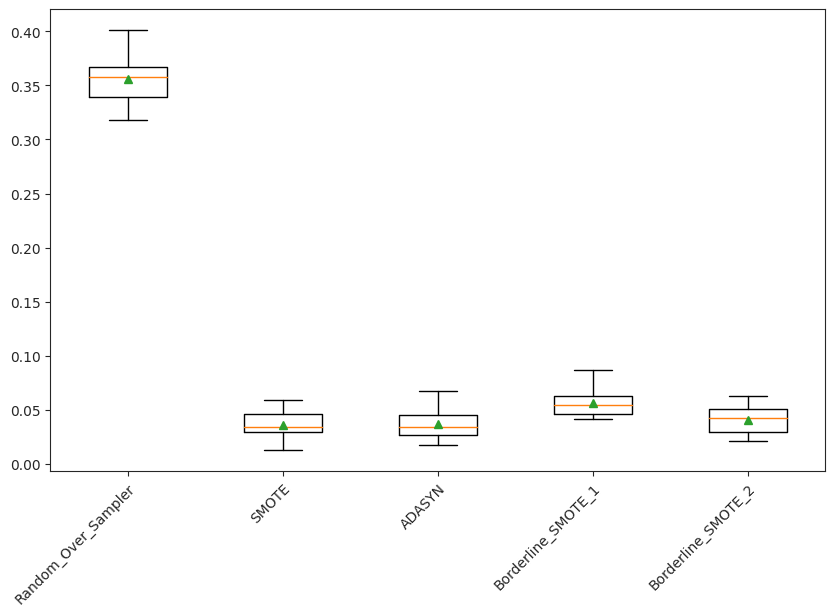

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))

plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Hyper parameter tuning for lightGBM

In [ ]:
model = LGBMClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'boosting_type': ['gbdt', 'goss']
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
lgbm_grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=make_scorer(fbeta_score, beta=2), verbose=True, n_jobs=-1)

In [ ]:
lgbm_grid.fit(X_train, y_train)

Fitting 30 folds for each of 6 candidates, totalling 180 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 2876, number of negative: 32124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3900
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082171 -> initscore=-2.413203
[LightGBM] [Info] Start training from sco

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'goss'],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=True)

In [ ]:
lgbm_grid.best_params_

{'boosting_type': 'goss', 'n_estimators': 200}

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Best-Threshold=6.66%, G-Mean=63.67%


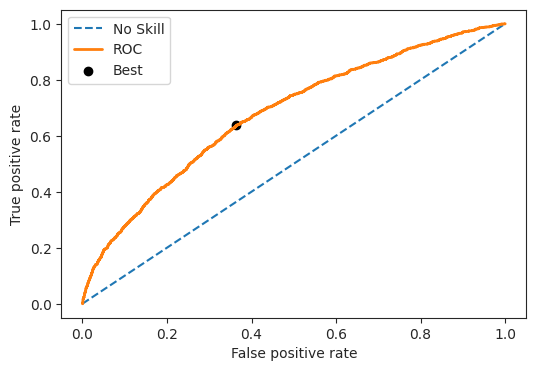

In [ ]:
gen_roc_curve(y_test, lgbm_grid.predict_proba(X_test)[:, 1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


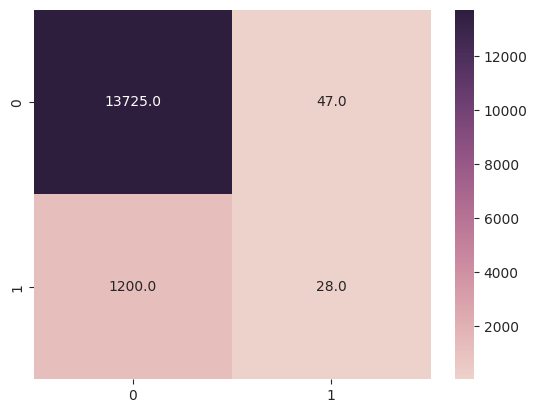

In [ ]:
conf_matrix(y_test, lgbm_grid.predict(X_test))

### Train the model on the entire dataset

In [ ]:
#y = X_scaled['TARGET']
y = X['TARGET']
#X_scaled.drop(columns=['TARGET'], inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(labels='SK_ID_CURR', axis=1), y, test_size=0.3, random_state=42)

In [ ]:
model = LGBMClassifier(n_estimators=200, boosting_type='goss')

In [ ]:
model.fit(X_train, y_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 16194, number of negative: 180387
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 196581, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082378 -> initscore=-2.410464
[LightGBM] [Info] Start training fro

LGBMClassifier(boosting_type='goss', n_estimators=200)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Best-Threshold=8.28%, G-Mean=65.79%


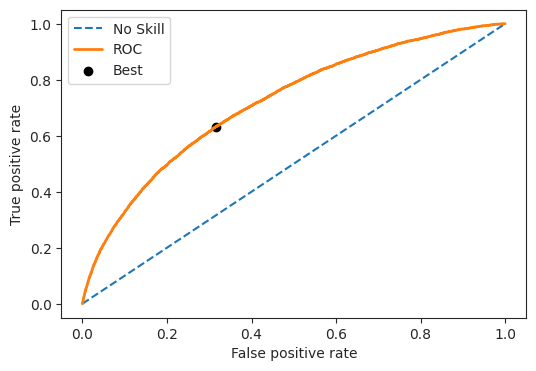

In [ ]:
gen_roc_curve(y_test, model.predict_proba(X_test)[:, 1])

### Training using Random Over sampler

In [ ]:
#smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
ros = RandomOverSampler(sampling_strategy='auto',
                                    random_state=101)
gbm = LGBMClassifier(n_estimators=200, boosting_type='goss')

pipe = Pipeline([('Oversampler', ros), ('light_gbm', gbm)])

In [ ]:
pipe.fit(X_train, y_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 180387, number of negative: 180387
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4006
[LightGBM] [Info] Number of data points in the train set: 360774, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('Oversampler', RandomOverSampler(random_state=101)),
                ('light_gbm',
                 LGBMClassifier(boosting_type='goss', n_estimators=200))])

In [ ]:
precision, recall, f1, accuracy = perform_metrics(y_test, pipe.predict(X_test))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [ ]:
print(f"The precision is: {precision}")
print(f"The recall is: {recall}")
print(f"The f1 is: {f1}")
print(f"The accuracy is: {accuracy}")

The precision is: 0.1556371143479757
The recall is: 0.6026646928201332
The f1 is: 0.24738697131745263
The accuracy is: 0.7059905755557929


In [ ]:
pipe.predict(X_test)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([1, 0, 0, ..., 1, 0, 1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


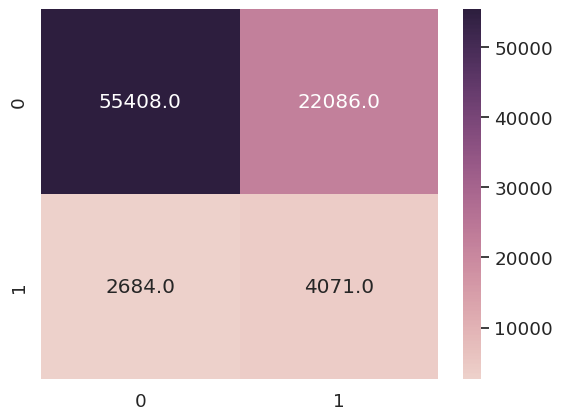

In [ ]:
gen_conf_matrix(y_test.tolist(), pipe.predict(X_test).tolist())

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Normalized confusion matrix
[[0.71499729 0.28500271]
 [0.39733531 0.60266469]]


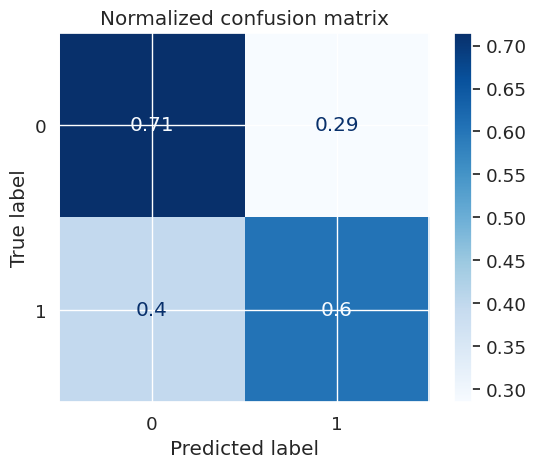

In [ ]:
titles_options = [
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        display_labels=[0, 1],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Best-Threshold=46.35%, G-Mean=66.04%


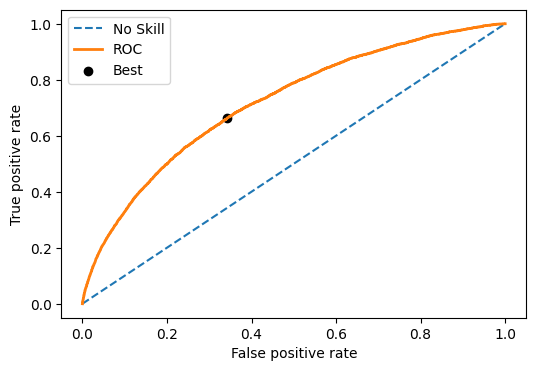

In [ ]:
gen_roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])

### Save model

In [ ]:
joblib.dump(pipe, path+'my_gbm.pkl')

['/content/drive/My Drive/OCL/P7/data/my_gbm.pkl']

## Training another classifier - XGBoost

In [73]:
xgb_classifier = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.001],
    'subsample': [0.8, 0.9]
}

In [57]:
sk_ids

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
280825    456251
280826    456252
280827    456253
280828    456254
280829    456255
Name: SK_ID_CURR, Length: 280830, dtype: int64

In [59]:
X_scaled['TARGET'] = sk_ids
X_small = X_scaled.sample(frac=1).head(15000)
y_small = X_small['TARGET']
X_small.drop(columns=['TARGET'], inplace=True, errors="ignore")
X_scaled.drop(columns=['TARGET'], inplace=True, errors="ignore")

<ipython-input-59-34a221f7b7dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled['TARGET'] = sk_ids
<ipython-input-59-34a221f7b7dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled.drop(columns=['TARGET'], inplace=True, errors="ignore")


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

In [61]:
X_train.shape, X_test.shape

((10500, 25), (4500, 25))

In [76]:
xgb_grid = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, verbose=True)

In [77]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


ValueError: ignored

In [ ]:
xgb_grid.best_params_

**Now let's train on the whole dataset**

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(labels='SK_ID_CURR', axis=1, errors="ignore"), y, test_size=0.3, random_state=42)

In [79]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8)

In [80]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
precision_test, recall_test, f1_test, accuracy_test = perform_metrics(y_test, xgb_model.predict(X_test))
precision_train, recall_train, f1_train, accuracy_train = perform_metrics(y_train, xgb_model.predict(X_train))

In [82]:
f2_test = fbeta_score(y_test, xgb_model.predict(X_test), beta=2)
f2_train = fbeta_score(y_train, xgb_model.predict(X_train), beta=2)

In [83]:
print(f"The precision is: {precision_test}")
print(f"The recall is: {recall_test}")
print(f"The f1 is: {f1_test}")
print(f"The accuracy is: {accuracy_test}")

The precision is: 0.42105263157894735
The recall is: 0.008290155440414507
The f1 is: 0.016260162601626015
The accuracy is: 0.9195717456587021


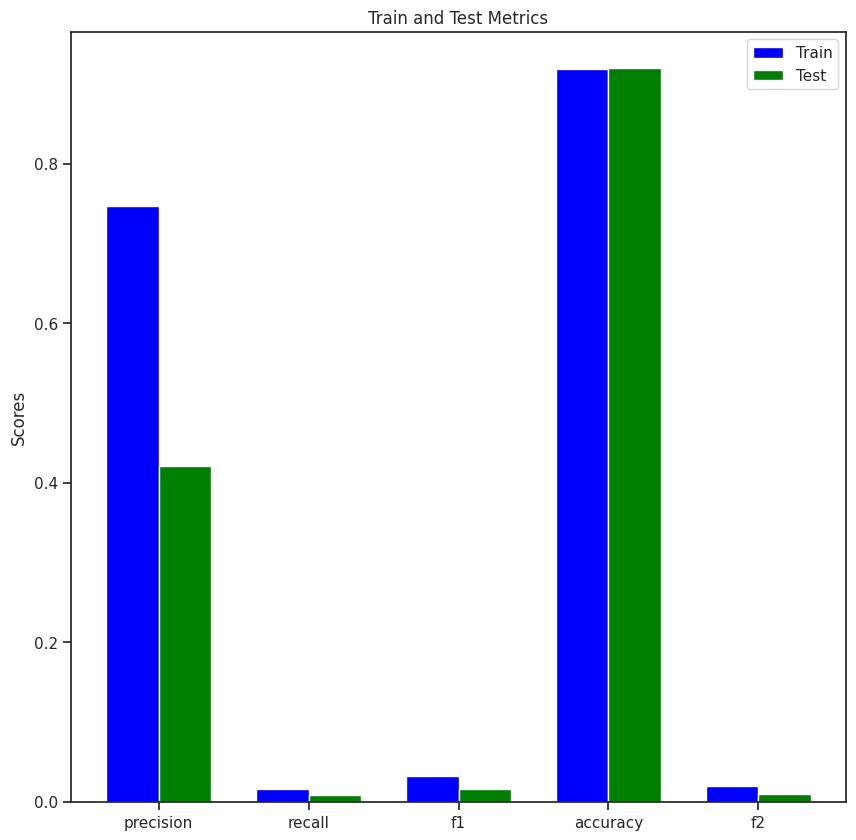

In [84]:
metrics = ['precision', 'recall', 'f1', 'accuracy', 'f2']
train_data = [precision_train, recall_train, f1_train, accuracy_train, f2_train]
test_data = [precision_test, recall_test, f1_test, accuracy_test, f2_test]

# Number of metrics
num_metrics = len(metrics)

# Set the width of the bars
bar_width = 0.35

# Create an array of indices for the x-axis
x = np.arange(num_metrics)

# Create the bar chart
plt.bar(x - bar_width/2, train_data, bar_width, label='Train', color='b')
plt.bar(x + bar_width/2, test_data, bar_width, label='Test', color='g')

# Set the x-axis labels
plt.xticks(x, metrics)

# Set the y-axis label
plt.ylabel('Scores')

# Set the chart title
plt.title('Train and Test Metrics')

# Add a legend
plt.legend()

# Show the chart
plt.show()

Normalized confusion matrix
[[9.99006375e-01 9.93625313e-04]
 [9.91709845e-01 8.29015544e-03]]


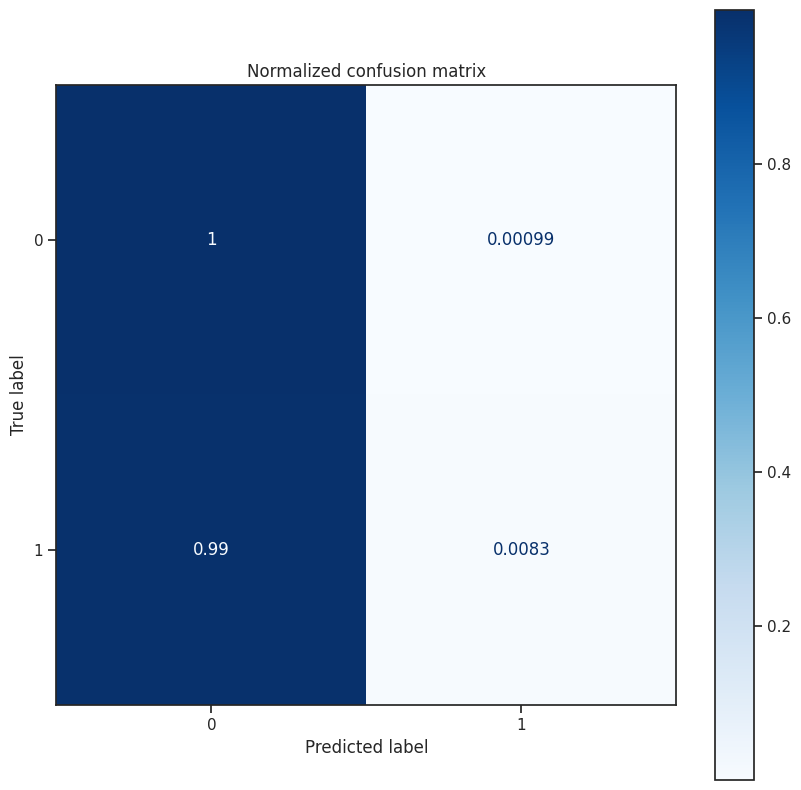

In [85]:
titles_options = [
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        xgb_model,
        X_test,
        y_test,
        display_labels=[0, 1],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Best-Threshold=7.79%, G-Mean=65.97%


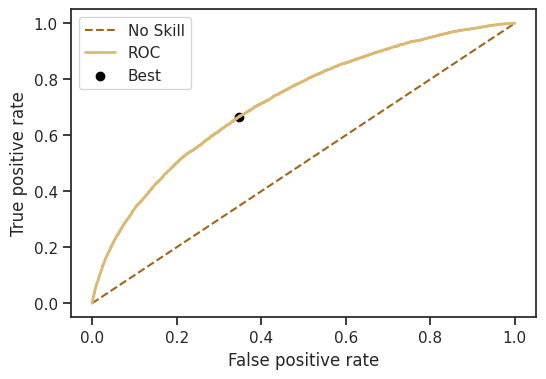

In [86]:
gen_roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

### Generating metrics for lgbm

In [87]:
import joblib
gbm_model = joblib.load(path+'my_gbm.pkl')

In [88]:
precision_test, recall_test, f1_test, accuracy_test = perform_metrics(y_test, gbm_model.predict(X_test))
precision_train, recall_train, f1_train, accuracy_train = perform_metrics(y_train, gbm_model.predict(X_train))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [89]:
f2_test = fbeta_score(y_test, gbm_model.predict(X_test), beta=2)
f2_train = fbeta_score(y_train, gbm_model.predict(X_train), beta=2)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


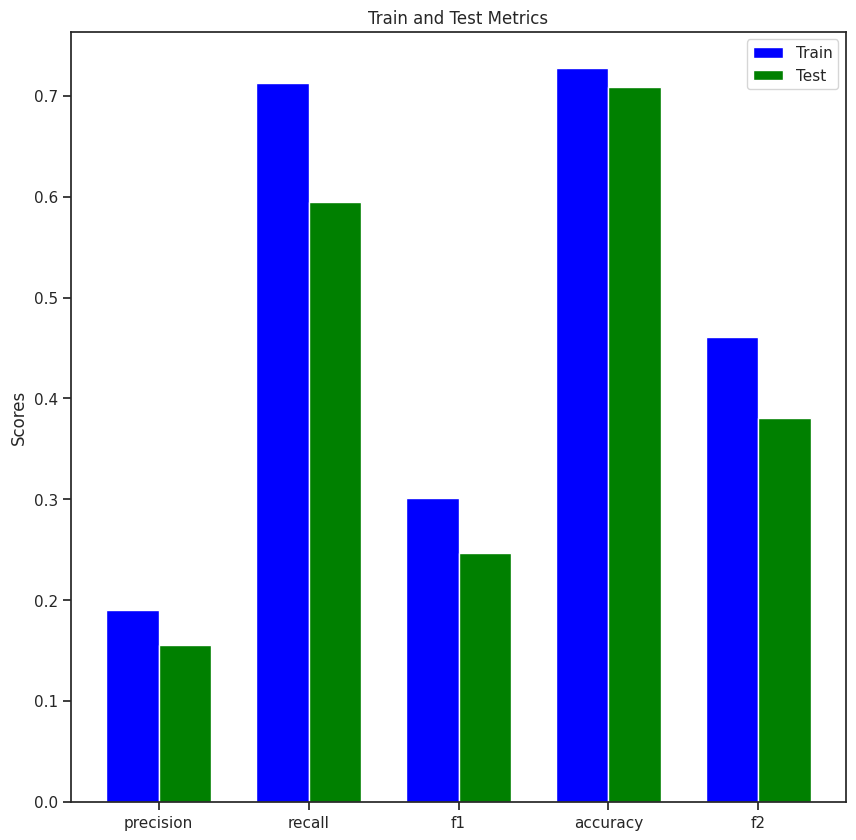

In [90]:
metrics = ['precision', 'recall', 'f1', 'accuracy', 'f2']
train_data = [precision_train, recall_train, f1_train, accuracy_train, f2_train]
test_data = [precision_test, recall_test, f1_test, accuracy_test, f2_test]

# Number of metrics
num_metrics = len(metrics)

# Set the width of the bars
bar_width = 0.35

# Create an array of indices for the x-axis
x = np.arange(num_metrics)

# Create the bar chart
plt.bar(x - bar_width/2, train_data, bar_width, label='Train', color='b')
plt.bar(x + bar_width/2, test_data, bar_width, label='Test', color='g')

# Set the x-axis labels
plt.xticks(x, metrics)

# Set the y-axis label
plt.ylabel('Scores')

# Set the chart title
plt.title('Train and Test Metrics')

# Add a legend
plt.legend()

# Show the chart
plt.show()

## Saving datasets in pickle formats

In [ ]:
X_train_26 = pd.read_csv(path+'X_train_45.csv')
X_test_26 = pd.read_csv(path+'X_test_45.csv')

In [ ]:
for column in X_train_26.columns:
  c_dtype = X_train_26[column].dtype
  if X_test_26[column].dtype != c_dtype:
    print(column + " has a type mismatch")

In [ ]:
for column in X_train_26.columns:
  if X_train_26[column].nunique() == 2:
    X_train_26[column] = X_train_26[column].astype('int8')
    X_test_26[column] = X_test_26[column].astype('int8')

In [ ]:
for column in X_train_26.columns:
  if X_train_26[column].dtype == 'float64':
    X_train_26[column] = X_train_26[column].astype('float32')
    X_test_26[column] = X_test_26[column].astype('float32')

In [ ]:
joblib.dump(X_train_26, path+'X_train_26.pkl')

['/content/drive/My Drive/OCL/P7/data/X_train_26.pkl']

In [ ]:
joblib.dump(X_test_26, path+'X_test_26.pkl')

['/content/drive/My Drive/OCL/P7/data/X_test_26.pkl']

In [ ]:
train_df = joblib.load(path+'X_train_26.pkl')

In [ ]:
test_df = joblib.load(path+'X_test_26.pkl')

In [ ]:
model = joblib.load(path+'model.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import shap
from sklearn.preprocessing import StandardScaler

In [ ]:
def scale_data(data):
    for column in test_df.columns:
        data[column] = data[column].astype(test_df[column].dtype)

    cont = data.select_dtypes(exclude='int8')
    binn = data.select_dtypes(include='int8')
    scaler = StandardScaler()
    scaler.fit(cont.drop(labels='SK_ID_CURR', axis=1))
    scaled_cont = scaler.transform(cont.drop(labels='SK_ID_CURR', axis=1))
    scaled_cont = pd.DataFrame(scaled_cont, columns=cont.drop(labels='SK_ID_CURR', axis=1).columns)
    res = pd.concat([scaled_cont, binn], axis=1)
    res['SK_ID_CURR'] = data['SK_ID_CURR']
    return res

In [ ]:
test_df_scaled = scale_data(test_df)

In [ ]:
test_df_scaled

,AMT_INCOME_TOTAL,AMT_CREDIT,EXT_SOURCE_2,repayment_time_months,number_of_previous_loans,previous_amount_credit,number_of_years_since_last_decision,prev_contrat_statut_canceled_unused,prev_contrat_statut_refused,prev_contrat_type_consumer_loans,...,MONTHS_BALANCE_x,CNT_INSTALMENT,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,FLAG_OWN_CAR_No,FLAG_OWN_REALTY_Yes,CNT_FAM_MEMBERS_two,SK_ID_CURR
0,-0.426056,0.142611,1.506371,1.704466,-0.938077,-0.919414,1.625776,-0.630921,-0.487316,-0.624297,...,-2.053675,-1.331750,0.249473,-0.253087,-0.241486,-0.159169,1,1,1,100001
1,-0.781053,-0.805441,-1.245626,-0.664539,-0.721930,-0.942717,-0.648691,-0.132639,-0.487316,-0.624297,...,0.594174,-0.370381,0.249473,-0.253087,-0.241486,-0.159169,1,1,1,100005
2,0.239562,0.401421,1.009753,-1.138341,-0.289634,-0.150987,-0.161305,-0.132639,-0.487316,-0.091276,...,0.112747,0.839308,-3.401877,0.372113,2.446753,1.304475,0,1,1,100013
3,1.348926,2.899377,-0.040815,2.336201,-0.073486,-0.485206,0.326080,0.365642,-0.487316,0.441745,...,-0.512602,0.710204,-1.051008,-0.292781,1.976964,0.430960,1,1,0,100028
4,0.017689,0.297956,-0.504952,0.440996,-0.721930,0.818857,-0.973615,-0.132639,-0.487316,-0.624297,...,0.543792,-0.332925,0.249473,-0.253087,-0.241486,-0.159169,0,0,0,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45924,-0.559180,-0.285452,0.726750,1.072731,-0.938077,0.530883,-0.323767,-0.630921,-0.487316,-1.157319,...,0.568983,0.509834,0.249473,-0.253087,-0.241486,-0.159169,1,1,0,456221
45925,-0.204184,0.289498,0.925805,0.440996,-0.289634,-0.448881,1.138390,-0.630921,-0.487316,0.441745,...,-0.018579,0.638905,0.249473,-0.253087,-0.241486,-0.159169,1,0,0,456222
45926,0.239562,-0.552745,0.639408,-1.296274,-0.721930,-0.236513,-0.973615,-0.630921,-0.487316,-0.091276,...,-1.484485,-0.763870,0.249473,-0.253087,-0.241486,-0.159169,0,1,0,456223
45927,0.461435,-0.182875,-0.394354,0.125129,-0.073486,-0.267529,0.586020,-0.132639,0.558349,0.441745,...,-0.081918,0.488690,0.249473,-0.253087,-0.241486,-0.159169,1,0,1,456224


In [ ]:
explainer = shap.Explainer(model.named_steps['lgbmclassifier'], test_df_scaled)

In [ ]:
shap_values = explainer(test_df)

100%|===================| 45879/45929 [09:58<00:00]       

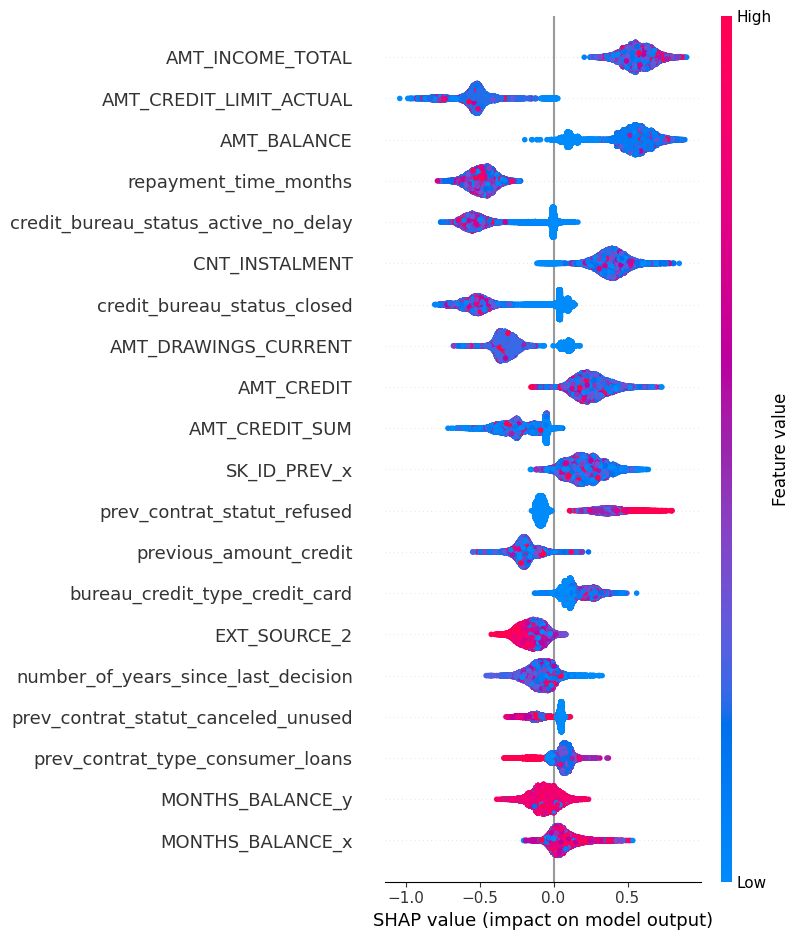

In [ ]:
shap.summary_plot(shap_values, test_df)

In [ ]:
other_shap = explainer.shap_values(test_df_scaled)

100%|===================| 45839/45929 [06:33<00:00]       

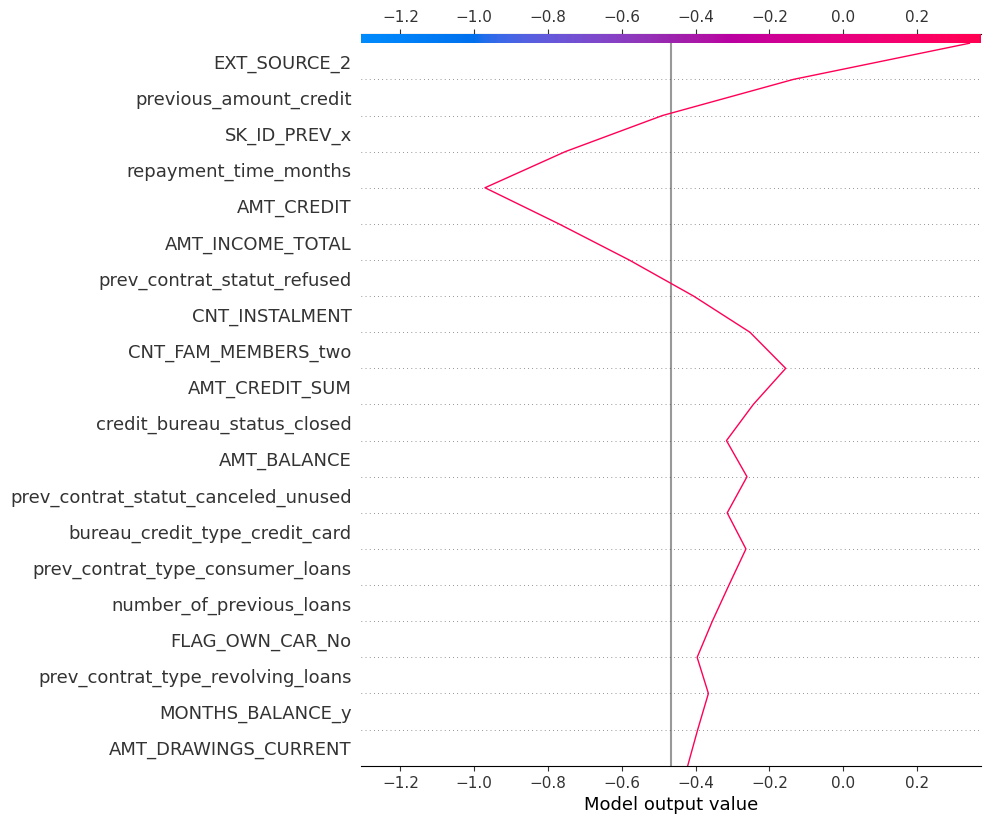

In [ ]:
shap.decision_plot(explainer.expected_value, other_shap[1], test_df.columns)